In [ ]:
!pip install split_folders

imports

In [ ]:
import tensorflow as tf
import sklearn
import splitfolders
import os
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

goes through copied dataset and removes gdot files which had to be done as gdot files could not be processed.

In [ ]:
input_folder = "/content/drive/MyDrive/machine vision/copieddata"

In [ ]:
#does not need to be ran again
for class_dir in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_dir)
    if not os.path.isdir(class_path):
        continue

    for filename in os.listdir(class_path):
        if filename.startswith('.') or not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(class_path, filename)
            print(f"Removing: {file_path}")
            os.remove(file_path)

copies dataset into new folder splitting the data into 80% training 20% test

In [ ]:
#does not need to be executed again
output = "/content/drive/MyDrive/machine vision/splitdata" #Enter Output Folder

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8,0.2))

Copying files: 8 files [00:22,  1.93s/ files]

KeyboardInterrupt: 

source: https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

creates paths so that parts of dataset can be refrenced

In [ ]:
#does not need to be executed again
#create a zip of the dataset in Google Drive
!zip -r "/content/drive/MyDrive/machine_vision_dataset.zip" "/content/drive/MyDrive/machine vision/splitdata"


Scanning files .....


zip error: Interrupted (aborting)


copies zipped to local colab cache so that it is faster to refrence

In [ ]:

!cp "/content/drive/MyDrive/machine_vision_dataset.zip" /content/
!unzip /content/machine_vision_dataset.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_170.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_184.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_212.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_172.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_141.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_21.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_155.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_252.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_13.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/splitdata/val/JN/JN_1025.jpg  
  inflating: /content/content/drive/MyDrive/machine vision/s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path   = '/content/content/drive/MyDrive/machine vision/splitdata'
train_path = '/content/content/drive/MyDrive/machine vision/splitdata/train'  #creates paths for training and testing
validity_path = '/content/content/drive/MyDrive/machine vision/splitdata/val'

creates both datasets so that all images are resized in them and uses batches as trying to train on all the images all at once breaks model, creates class names form folders

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(240, 240),  # resizes pictures
    batch_size=32 #number of training samples processed in one go
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    validity_path,
    image_size=(240, 240),
    batch_size=32
)

class_names = train_dataset.class_names #classes can be automatically found from folder names
print(class_names)  #creates class names from folders



Found 21935 files belonging to 75 classes.
Found 5488 files belonging to 75 classes.
['B', 'CC', 'CL', 'CM', 'CN', 'CS', 'CU', 'CXD', 'CXI', 'D', 'DB', 'DEC', 'DEE', 'DEF', 'DEG_1', 'DEG_2', 'DER', 'DES', 'EX', 'FC', 'FL', 'FM', 'FS', 'H', 'ID', 'IG', 'ING', 'INGF', 'INGZ', 'IR', 'IS', 'JDL', 'JDM_1', 'JDM_2', 'JN', 'JX', 'JXB', 'JXD', 'LD', 'LL', 'LR', 'LU', 'LX', 'MB', 'MC', 'MM', 'OB', 'OBB', 'OBC', 'OBI', 'OBM', 'OBP', 'OBS', 'OBX', 'OJL', 'OJM', 'RF', 'RM_1', 'RM_2', 'RT', 'SAP', 'SAV', 'SCP', 'SR', 'SRC', 'SRP', 'SRV', 'SS', 'SV', 'SW', 'VR', 'VV', 'WL', 'XB', 'XP']


creates class weights as each class does not have the same amount of pictures

In [ ]:
def calculate_class_weights(train_dataset):
    label_list = []

    for _, label_batch in train_dataset:
        label_list.extend(label_batch.numpy())  # append batch labels

    label_counts = Counter(label_list)
    total_samples = sum(label_counts.values())
    num_classes = len(label_counts)

    class_weights = {
        class_id: total_samples / (num_classes * count)
        for class_id, count in label_counts.items()
    }

    return class_weights

# calculates class weights
class_weights = calculate_class_weights(train_dataset)

# prints some sample weights
for k in list(class_weights.keys())[:5]:
    print(f"Class {k}: weight {class_weights[k]:.4f}")

Class 20: weight 0.3688
Class 72: weight 0.3775
Class 12: weight 0.3770
Class 55: weight 1.6379
Class 21: weight 1.4104


In [ ]:
#other way to create class weights
# Collect all labels from the dataset
all_labels = []

# Flatten batches so you can go through every image in the dataset
for _, label_batch in train_dataset.unbatch():
    all_labels.append(label_batch.numpy())

all_labels = np.array(all_labels)

# Compute weights
class_weights_array = compute_class_weight(
    class_weight = "balanced",        # Apply the same formula you wrote
    classes = np.unique(all_labels),  # List of class IDs
    y = all_labels                    # All labels from your dataset
)

# Convert to dictionary {class_id: weight}
class_weights = dict(zip(np.unique(all_labels), class_weights_array))

min_weight = 0.35
max_weight = 20.0   # cap very large weights (most classes between 0-20 some at 300!)
class_weights = {
    cls: (0.0 if w > max_weight else max(w, min_weight))
    for cls, w in class_weights.items()
}

# prints some sample weights
for k in list(class_weights.keys())[:30]:
    print(f"Class {k}: weight {class_weights[k]:.4f}")

Class 0: weight 0.3500
Class 1: weight 0.3500
Class 2: weight 0.3500
Class 3: weight 1.8806
Class 4: weight 0.3635
Class 5: weight 7.4306
Class 6: weight 0.0000
Class 7: weight 6.9239
Class 8: weight 0.4867
Class 9: weight 0.4500
Class 10: weight 3.2410
Class 11: weight 0.7913
Class 12: weight 0.3770
Class 13: weight 0.4383
Class 14: weight 0.3842
Class 15: weight 0.0000
Class 16: weight 0.3808
Class 17: weight 0.3808
Class 19: weight 0.3729
Class 20: weight 0.3688
Class 21: weight 1.4104
Class 22: weight 8.0172
Class 23: weight 0.3733
Class 24: weight 4.6870
Class 25: weight 16.0344
Class 26: weight 0.0000
Class 27: weight 0.0000
Class 28: weight 0.0000
Class 29: weight 5.7482
Class 30: weight 3.4620


can now run

In [ ]:
train_dataset = train_dataset.shuffle(200).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

used to run faster

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  #uses both 16 and 32 bit to run faster and use less memory


creates CNN

In [ ]:
num_classes = 75

base_model = tf.keras.applications.EfficientNetB1(  #creates model using efficientnet
    include_top=False,
    input_shape=(240, 240, 3),  #image size
    pooling='max',      #layer that reduces dimensions whilst trying to keep important parts
    weights='imagenet'
)
#data_augmentation = tf.keras.Sequential([
   #tf.keras.layers.RandomFlip("horizontal"),
    #tf.keras.layers.RandomRotation(0.05),
    #tf.keras.layers.RandomZoom(0.05),
    #tf.keras.layers.RandomContrast(0.05),
    #tf.keras.layers.RandomTranslation(0.1, 0.1) #augmentations to make images more random which should result in better accuracy
#])                                              #as CNN trains on more images

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), #normalises images
    #data_augmentation,
    base_model,                                     #creates model
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(512, activation='relu'),
   #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, dtype='float32'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
for images, labels in train_dataset.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels:", labels.numpy())


Train batch shape: (32, 240, 240, 3)
Train labels: [12 39 50 17  0  1 17 32 63  9 53 72 72  0 10 57 17 19 56 54 16  4 40 56
 23 73 20 12 20 20  4  1]


learning rate schedule

In [ ]:
initial_lr = 1e-3  # starting learning rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=3038,  # how often
    decay_rate=0.98,   # how much each step
    staircase=True     # true = discrete,false = smooth
)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,    # halve learning rate
    patience=2,    # wait 2 epochs of no improvement
    min_lr=1e-6,  # don’t go below this
    min_delta=0.01
)


In [ ]:
#callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = [myCallback(), reduce_lr]

compiles model

In [ ]:
model.compile(
       optimizer=optimizer, #compiles model
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
       metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=15,
                    #class_weight = class_weights, #something to do with class weights
                    callbacks=[callbacks])

Epoch 1/15
685/686 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1595 - loss: 4.2067

KeyboardInterrupt: 

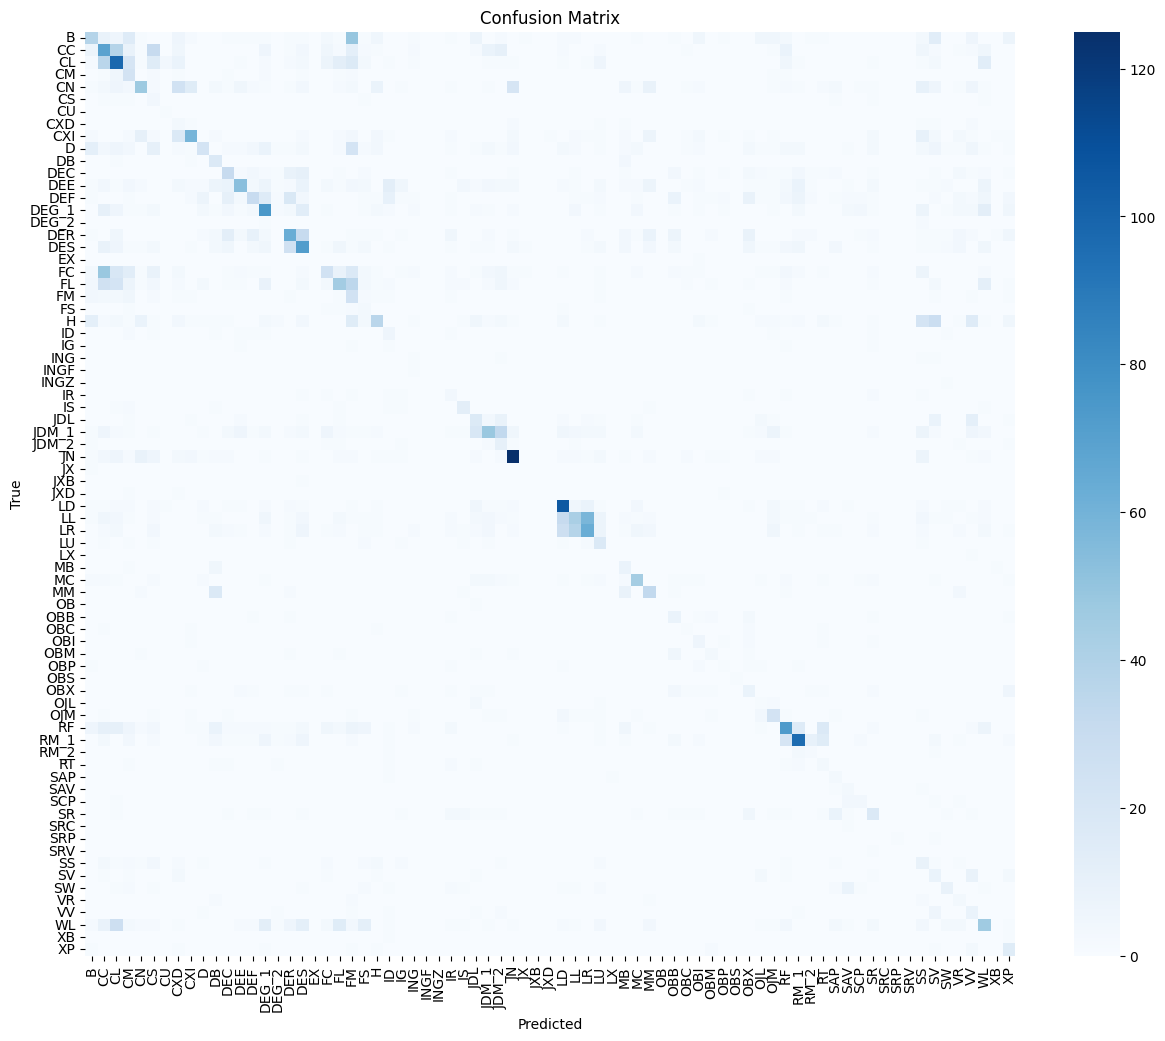

              precision    recall  f1-score   support

           B       0.36      0.18      0.24       212
          CC       0.25      0.28      0.27       245
          CL       0.34      0.36      0.35       271
          CM       0.16      0.56      0.24        41
          CN       0.51      0.22      0.31       210
          CS       0.03      0.36      0.06        11
          CU       0.17      1.00      0.29         1
         CXD       0.03      0.25      0.06        12
         CXI       0.61      0.38      0.47       157
           D       0.42      0.13      0.20       170
          DB       0.21      0.75      0.33        24
         DEC       0.33      0.32      0.32        97
         DEE       0.57      0.26      0.36       203
         DEF       0.42      0.17      0.24       174
       DEG_1       0.41      0.38      0.39       199
       DEG_2       0.00      0.00      0.00         3
         DER       0.42      0.31      0.36       201
         DES       0.34    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get true labels and predictions for val_dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)  # predictions
    y_true.extend(labels.numpy())              # true labels
    y_pred.extend(np.argmax(preds, axis=1))    # predicted class indices

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plot it
plt.figure(figsize=(15, 12))
sns.heatmap(cm,
            annot=False,
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 4. (Optional) Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
#train vs val loss

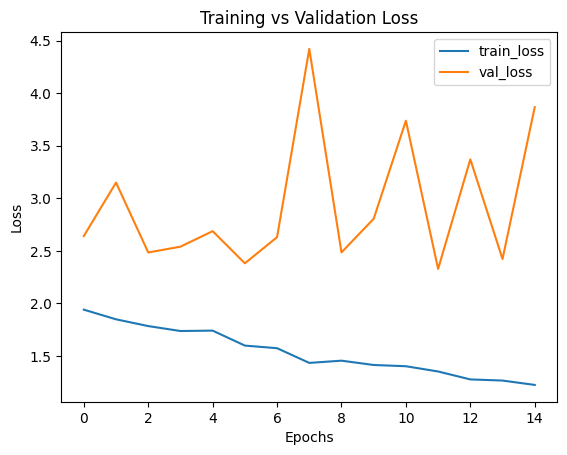

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


train vs val accuracy

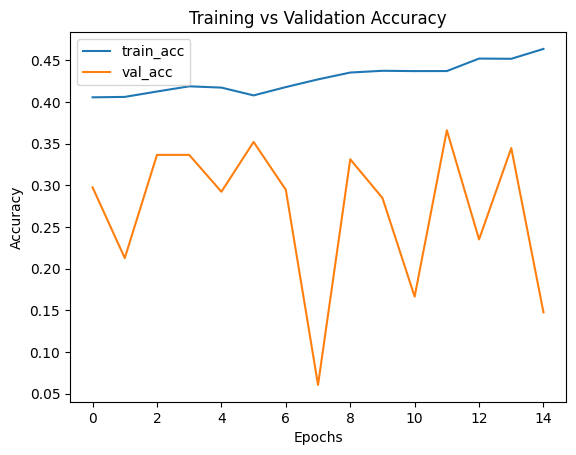

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


model compiles however accuracy is at 81%, must use GPU instead of CPU when compiling, training also takes a long time


In [ ]:
inputs = tf.keras.Input(shape=(240,240,3))
x = base(inputs, training=True)          # batch norm updated
x = layers.Dense(128, activation='relu')(x)
logits = layers.Dense(num_classes, dtype='float32')(x)
test_model = tf.keras.Model(inputs, logits)

test_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Single batch
history = test_model.fit(images, labels, epochs=50)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step - accuracy: 0.0000e+00 - loss: 4.3843
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0625 - loss: 3.9335
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3438 - loss: 3.4407
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5312 - loss: 3.0415
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4375 - loss: 2.6747
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5312 - loss: 2.3203
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5000 - loss: 1.9539
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5625 - loss: 1.6613
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7500 - loss: 1.4459
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8125 - loss: 1.2162
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9688 - loss: 0.8844
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.71